In [1]:
import random as rd
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap
import statistics as stat
import math
import pandas as pd

### The data

In [2]:
N=500
xgauss1=[rd.gauss(mu=0,sigma=1) for i in range(N)]
xgauss2=[rd.gauss(0,1) for i in range(N)]

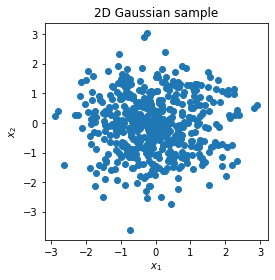

In [3]:
plt.figure(figsize=(4,4))
plt.scatter(xgauss1,xgauss2)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('2D Gaussian sample')
plt.show()

### A labeled Data Set

In [27]:
group1=np.random.multivariate_normal([2.5,2.5],
                                     [[2,-0.8],[-0.8,2]],1000)
group2=np.random.multivariate_normal([0,0],
                                     [[1,0],[0,1]],2000)

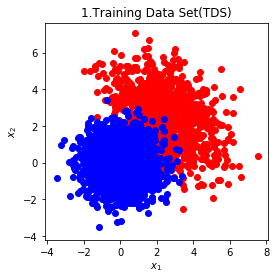

In [28]:
plt.figure(figsize=(4,4))
plt.scatter(group1[:,0],group1[:,1],c='red')
plt.scatter(group2[:,0],group2[:,1],c='blue')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('1.Training Data Set(TDS)')
plt.show()

### New data inputs without label

In [29]:
x1_min = min(np.concatenate((group1[:,0],group2[:,0])))
x1_max = max(np.concatenate((group1[:,0],group2[:,0])))
x2_min = min(np.concatenate((group1[:,1],group2[:,1])))
x2_max = max(np.concatenate((group1[:,1],group2[:,1])))
Neval=15
h1=(x1_max-x1_min)/Neval
h2=(x2_max-x2_min)/Neval
x1Eval,x2Eval = np.meshgrid(np.arange(x1_min,x1_max,h1),np.arange(x2_min,x2_max,h2))

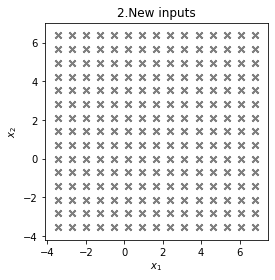

In [30]:
plt.figure(figsize=(4,4))
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('2.New inputs')
for x1 in x1Eval:
    for x2 in x2Eval:
        plt.scatter(x1,x2,marker='x',c='gray')

## The naive Bayes model

In [31]:
data1 = pd.DataFrame({'x1':group1[:,0],'x2':group1[:,1],'label':[1 for i in range(group1.shape[0])]})
data2 = pd.DataFrame({'x1':group2[:,0],'x2':group2[:,1],'label':[0 for i in range(group2.shape[0])]})
#our final data set
data=pd.concat([data1,data2],ignore_index=True)


In [61]:
# the prior probability for each given class
def prior_prob(data=data):
    counts = data.label.value_counts()
    prob = counts/data.shape[0]
    return prob

# the Likelihood probability with each input for each class
def estm(data=data):
    params = {'mu':[], 'var':[]}
    for label in data.label.unique():
        subset = data[data['label']==label]
        x = subset.loc[:,['x1','x2']]
        mu = subset.loc[:,['x1','x2']].mean(axis=0)
        covar = np.dot((x-mu).T,(x-mu))/subset.shape[0]
        params['mu'].append(mu)
        params['var'].append(covar)
    return params

# the posterior probability of each observation 
def post_prob(x, mle_res, prior_res):
    n = 0
    res = []
    labels = data.label.unique()
    for label in labels:
        mu = mle_res['mu'][n].to_numpy()
        var = mle_res['var'][n]

        f_x = 1/((2*math.pi)**(x.shape[0]/2) * math.sqrt(np.linalg.det(var))) * math.exp(-1/2 * ((x-mu).T).dot(np.linalg.inv(var)).dot(x-mu))
        sigma_y = math.log(f_x) + math.log(prior_res[n])
        res.append(sigma_y)
        n = n+1
    index_pre = np.argmax(res)
    return labels[index_pre]

In [62]:
prior_prob = prior_prob(data)
mle_res = estm(data)

data['label_pred'] = np.nan
data

,x1,x2,label,label_pred
0,1.376291,4.365251,1,NaN
1,4.029951,0.305684,1,NaN
2,2.130626,2.321851,1,NaN
3,1.172674,1.944162,1,NaN
4,3.653995,1.547754,1,NaN
...,...,...,...,...
2995,0.875147,0.095262,0,NaN
2996,0.516804,0.442500,0,NaN
2997,-1.527932,-0.395909,0,NaN
2998,0.187795,0.853499,0,NaN


In [63]:
for i in range(data.shape[0]):
    x = data.iloc[i,:2]
    data.loc[i,'label_pred'] = post_prob(x,mle_res,prior_prob)

In [64]:
data

,x1,x2,label,label_pred
0,1.376291,4.365251,1,1.0
1,4.029951,0.305684,1,1.0
2,2.130626,2.321851,1,1.0
3,1.172674,1.944162,1,1.0
4,3.653995,1.547754,1,1.0
...,...,...,...,...
2995,0.875147,0.095262,0,0.0
2996,0.516804,0.442500,0,0.0
2997,-1.527932,-0.395909,0,0.0
2998,0.187795,0.853499,0,0.0


### Evaluation of the model

In [65]:
N = data.shape[0]

# number of errors
err = N-sum(data.loc[:,'label']==data.loc[:,'label_pred'])
# number of false positive
FP = sum([(data.loc[i,'label']==0) & (data.loc[i,'label_pred']==1) for i in range(data.shape[0])])
# number of false negative
FN = sum([(data.loc[i,'label']==1) & (data.loc[i,'label_pred']==0) for i in range(data.shape[0])])

print({'error':err,'FP':FP,'FN':FN})

{'error': 140, 'FP': 112, 'FN': 28}


In [66]:
# accuracy
acc = (N-err)/N
# precision
TP = sum([(data.loc[i,'label']==1) & (data.loc[i,'label_pred']==1) for i in range(data.shape[0])])
precision = TP/(TP+FP)
# recall
recall = TP/(TP+FN)
# F1-score
F1_score = 2/(1/precision + 1/recall)
print({'accuracy':acc,'precision':precision,'recall':recall,'F1-score':F1_score})

{'accuracy': 0.9533333333333334, 'precision': 0.8966789667896679, 'recall': 0.972, 'F1-score': 0.9328214971209211}


### Class Prediction for new inputs using the calibrated naive Bayes model

In [67]:
# new inputs dataset
new_inputs = pd.DataFrame({'x1':x1Eval.flatten(),'x2':x2Eval.flatten()})
new_inputs

,x1,x2
0,-3.449961,-3.536544
1,-2.718591,-3.536544
2,-1.987221,-3.536544
3,-1.255851,-3.536544
4,-0.524481,-3.536544
...,...,...
220,3.863739,6.381005
221,4.595109,6.381005
222,5.326479,6.381005
223,6.057849,6.381005


In [68]:
# make predictions for new inputs
for i in range(new_inputs.shape[0]):
    x = new_inputs.iloc[i,:2]
    new_inputs.loc[i,'label_pred'] = post_prob(x,mle_res,prior_prob)

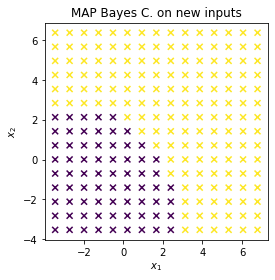

In [69]:
plt.figure(figsize=(4,4))
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('MAP Bayes C. on new inputs')
plt.scatter(new_inputs.x1,new_inputs.x2,marker='x',c=new_inputs.label_pred)

## The Scikit learn library

### Calibration and fit of the model using Scikit learn.

In [95]:
data

,x1,x2,label,label_pred
0,1.376291,4.365251,1,1.0
1,4.029951,0.305684,1,1.0
2,2.130626,2.321851,1,1.0
3,1.172674,1.944162,1,1.0
4,3.653995,1.547754,1,1.0
...,...,...,...,...
2995,0.875147,0.095262,0,0.0
2996,0.516804,0.442500,0,0.0
2997,-1.527932,-0.395909,0,0.0
2998,0.187795,0.853499,0,0.0


In [99]:
from sklearn.naive_bayes import GaussianNB
#initial data set: X (inputs), y (output).
X,y = data.loc[:,['x1','x2']], data.loc[:,'label']
gnb = GaussianNB(); gnbfit=gnb.fit(X, y); y_pred = gnbfit.predict(X)

### Model parameter analysis.

In [107]:
res = {'class_count': gnb.class_count_, 'class_prior':gnb.class_prior_, 'classes':gnb.classes_, 'theta':gnb.theta_, 'sigma':gnb.sigma_}
for key,val in res.items():
    print('The {0} of results is {1}'.format(key,val) )

The class_count of results is [2000. 1000.]
The class_prior of results is [0.66666667 0.33333333]
The classes of results is [0 1]
The theta of results is [[-5.87383921e-03 -1.29319821e-03]
 [ 2.52022929e+00  2.51098729e+00]]
The sigma of results is [[0.98185719 0.95194053]
 [2.13619887 2.13616676]]


Here we can see that for the results of variance matrix(sigma), it kept only the values on the diagonal, which means each dimension of the x are independent to each other. And this is actually the hypothesis and the base of Naive Bayes model.

### Accuracy, precision, recall and F1-score

In [110]:
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y, y_pred))
print("Precision:",metrics.precision_score(y, y_pred))
print("Recall:",metrics.recall_score(y, y_pred))
print("F1-score:",metrics.f1_score(y, y_pred))

Accuracy: 0.962
Precision: 0.9403578528827038
Recall: 0.946
F1-score: 0.9431704885343967


### AUC indicator.

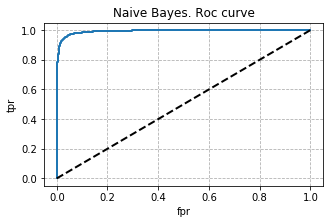

In [117]:
y_proba = gnbfit.predict_proba(X)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y, y_proba)
figure = plt.figure(figsize=(5,3))
plt.plot(fpr,tpr, linewidth = 2)
plt.title('Naive Bayes. Roc curve') 
plt.xlabel('fpr');plt.ylabel('tpr') 
plt.plot(tpr,tpr,"k--", linewidth = 2)
plt.grid(linestyle = 'dashed')
plt.show()

In [119]:
gnbfit.predict_proba(X)

array([[2.26968339e-04, 9.99773032e-01],
       [5.56238779e-03, 9.94437612e-01],
       [2.58470151e-02, 9.74152985e-01],
       ...,
       [9.97619281e-01, 2.38071910e-03],
       [9.52549481e-01, 4.74505185e-02],
       [9.93519221e-01, 6.48077909e-03]])

In [ ]:
df1 = pd.read_csv('spam.txt', sep=";")
df2 = pd.read_csv('SAheart.txt', sep=",")